# XGBoost training
This is an auto-generated notebook. To reproduce these results, attach this notebook to the **XXX_Demo_ML-CPU_Cluster_Python_SQL_STANDARDMODE** cluster and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/1860757565312910/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false)
- Navigate to the parent notebook [here](#notebook/1860757565312911) (If you launched the AutoML experiment using the Experiments UI, this link isn't very useful.)
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

Runtime Version: _11.2.x-cpu-ml-scala2.12_

In [ ]:
import mlflow
import databricks.automl_runtime

target_col = "cause_of_death"

## Load Data

In [ ]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)


# Download the artifact and read it into a pandas DataFrame
input_client = MlflowClient()
input_data_path = input_client.download_artifacts("d8b440f0b1cf44369cc713f42ff9abb4", "data", input_temp_dir)

df_loaded = pd.read_parquet(os.path.join(input_data_path, "training_data"))
# Delete the temp data
shutil.rmtree(input_temp_dir)

# Preview data
df_loaded.head(5)

,year,state,state_fips_code,hhs_region,age_range,benchmark,locality,observed_deaths,population,expected_deaths,potentially_excess_deaths,percent_potentially_excess_deaths,cause_of_death,_automl_sample_weight_4cd4,_automl_split_col_b928
0,2011,Louisiana,LA,6,0-74,Floating,Nonmetropolitan,335.0,726181.0,136.0,199.0,59.4,Unintentional Injury,1.439153,train
1,2011,Louisiana,LA,6,0-79,2010 Fixed,All,1856.0,4428395.0,860.0,996.0,53.7,Unintentional Injury,1.439153,train
2,2011,Louisiana,LA,6,0-84,2010 Fixed,Metropolitan,1573.0,3744926.0,758.0,815.0,51.8,Unintentional Injury,1.439153,train
3,2011,Louisiana,LA,6,0-84,Floating,All,1940.0,4506332.0,944.0,996.0,51.3,Unintentional Injury,1.439153,train
4,2011,Maine,ME,1,0-49,2005 Fixed,Nonmetropolitan,104.0,315414.0,49.0,55.0,52.9,Unintentional Injury,1.439153,train


### Select supported columns
Select only the columns that are supported. This allows us to train a model that can predict on a dataset that has extra columns that are not used in training.
`[]` are dropped in the pipelines. See the Alerts tab of the AutoML Experiment page for details on why these columns are dropped.

In [ ]:
from databricks.automl_runtime.sklearn.column_selector import ColumnSelector
supported_cols = ["locality", "year", "hhs_region", "percent_potentially_excess_deaths", "expected_deaths", "population", "state", "observed_deaths", "age_range", "state_fips_code", "benchmark", "potentially_excess_deaths"]
col_selector = ColumnSelector(supported_cols)

## Preprocessors

### Numerical columns

Missing values for numerical columns are imputed with mean by default.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

num_imputers = []
num_imputers.append(("impute_mean", SimpleImputer(), ["expected_deaths", "observed_deaths", "percent_potentially_excess_deaths", "population", "potentially_excess_deaths"]))

numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors="coerce"))),
    ("imputers", ColumnTransformer(num_imputers)),
    ("standardizer", StandardScaler()),
])

numerical_transformers = [("numerical", numerical_pipeline, ["percent_potentially_excess_deaths", "expected_deaths", "population", "observed_deaths", "potentially_excess_deaths"])]

### Categorical columns

#### Low-cardinality categoricals
Convert each low-cardinality categorical column into multiple binary columns through one-hot encoding.
For each input categorical column (string or numeric), the number of output columns is equal to the number of unique values in the input column.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

one_hot_imputers = []

one_hot_pipeline = Pipeline(steps=[
    ("imputers", ColumnTransformer(one_hot_imputers, remainder="passthrough")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore")),
])

categorical_one_hot_transformers = [("onehot", one_hot_pipeline, ["age_range", "benchmark", "hhs_region", "locality", "state", "state_fips_code", "year"])]

In [ ]:
from sklearn.compose import ColumnTransformer

transformers = numerical_transformers + categorical_one_hot_transformers

preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=1)

## Train - Validation - Test Split
The input data is split by AutoML into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters of the model)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

`_automl_split_col_b928` contains the information of which set a given row belongs to.
We use this column to split the dataset into the above 3 sets. 
The column should not be used for training so it is dropped after split is done.

In [ ]:
# AutoML completed train - validation - test split internally and used _automl_split_col_b928 to specify the set
split_train_df = df_loaded.loc[df_loaded._automl_split_col_b928 == "train"]
split_val_df = df_loaded.loc[df_loaded._automl_split_col_b928 == "val"]
split_test_df = df_loaded.loc[df_loaded._automl_split_col_b928 == "test"]

# Separate target column from features and drop _automl_split_col_b928
X_train = split_train_df.drop([target_col, "_automl_split_col_b928"], axis=1)
y_train = split_train_df[target_col]

X_val = split_val_df.drop([target_col, "_automl_split_col_b928"], axis=1)
y_val = split_val_df[target_col]

X_test = split_test_df.drop([target_col, "_automl_split_col_b928"], axis=1)
y_test = split_test_df[target_col]

## Train classification model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/1860757565312910/s?orderByKey=metrics.%60val_f1_score%60&orderByAsc=false)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment
- To view the full list of tunable hyperparameters, check the output of the cell below

In [ ]:
from xgboost import XGBClassifier

help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic', use_label_encoder: bool = True, **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : int
 |          Number of boosting rounds.
 |      use_label_encoder : bool
 |          (Deprecated) Use the label encoder from scikit-learn to encode the labels. For new
 |          code, we recommend that you set this parameter to False.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      learning_rate : Optional[float]
 |          Boosting learning rate (xgb's "eta")
 |      verbosity : Optional[int]
 |          The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 

In [ ]:
import mlflow
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from databricks.automl_runtime.sklearn import TransformedTargetClassifier

set_config(display="diagram")

xgbc_classifier = TransformedTargetClassifier(
    classifier=XGBClassifier(
        colsample_bytree=0.6925102629069848,
        learning_rate=0.16153054387601637,
        max_depth=8,
        min_child_weight=6,
        n_estimators=1573,
        n_jobs=100,
        subsample=0.7774586806850589,
        verbosity=0,
        random_state=538597927,
    ),
    transformer=LabelEncoder()  # XGBClassifier requires the target values to be integers between 0 and n_class-1
)

model = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
    ("classifier", xgbc_classifier),
])

# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
mlflow.sklearn.autolog(disable=True)
pipeline_val = Pipeline([
    ("column_selector", col_selector),
    ("preprocessor", preprocessor),
])
pipeline_val.fit(X_train, y_train)
X_val_processed = pipeline_val.transform(X_val)
label_encoder_val = LabelEncoder()
label_encoder_val.fit(y_train)
y_val_processed = label_encoder_val.transform(y_val)

model

Pipeline Pipeline(steps=[('column_selector',
 ColumnSelector(cols=['locality', 'year', 'hhs_region',
 'percent_potentially_excess_deaths',
 'expected_deaths', 'population', 'state',
 'observed_deaths', 'age_range',
 'state_fips_code', 'benchmark',
 'potentially_excess_deaths'])),
 ('preprocessor',
 ColumnTransformer(remainder='passthrough', sparse_threshold=1,
 transformers=[('nume...
 learning_rate=0.16153054387601637,
 max_delta_step=None,
 max_depth=8,
 min_child_weight=6,
 missing=nan,
 monotone_constraints=None,
 n_estimators=1573,
 n_jobs=100,
 num_parallel_tree=None,
 predictor=None,
 random_state=538597927,
 reg_alpha=None,
 reg_lambda=None,
 scale_pos_weight=None,
 subsample=0.7774586806850589,
 tree_method=None,
 validate_parameters=None,
 verbosity=0),
 transformer=LabelEncoder()))]) ColumnSelector ColumnSelector(cols=['locality', 'year', 'hhs_region',
 'percent_potentially_excess_deaths', 'expected_deaths',
 'population', 'state', 'observed_deaths', 'age_range',
 'state_fips_code', 'benchmark',
 'potentially_excess_deaths']) preprocessor: ColumnTransformer ColumnTransformer(remainder='passthrough', sparse_threshold=1,
 transformers=[('numerical',
 Pipeline(steps=[('converter',
 FunctionTransformer(func= at 0x7fbc87f04670>)),
 ('imputers',
 ColumnTransformer(transformers=[('impute_mean',
 SimpleImputer(),
 ['expected_deaths',
 'observed_deaths',
 'percent_potentially_excess_deaths',
 'population',
 'potential...
 ['percent_potentially_excess_deaths',
 'expected_deaths', 'population',
 'observed_deaths',
 'potentially_excess_deaths']),
 ('onehot',
 Pipeline(steps=[('imputers',
 ColumnTransformer(remainder='passthrough',
 transformers=[])),
 ('one_hot_encoder',
 OneHotEncoder(handle_unknown='ignore'))]),
 ['age_range', 'benchmark', 'hhs_region',
 'locality', 'state', 'state_fips_code',
 'year'])]) numerical ['percent_potentially_excess_deaths', 'expected_deaths', 'population', 'observed_deaths', 'potentially_excess_deaths'] FunctionTransformer FunctionTransformer(func= at 0x7fbc87f04670>) imputers: ColumnTransformer ColumnTransformer(transformers=[('impute_mean', SimpleImputer(),
 ['expected_deaths', 'observed_deaths',
 'percent_potentially_excess_deaths',
 'population', 'potentially_excess_deaths'])]) impute_mean ['expected_deaths', 'observed_deaths', 'percent_potentially_excess_deaths', 'population', 'potentially_excess_deaths'] SimpleImputer SimpleImputer() StandardScaler StandardScaler() onehot ['age_range', 'benchmark', 'hhs_region', 'locality', 'state', 'state_fips_code', 'year'] imputers: ColumnTransformer ColumnTransformer(remainder='passthrough', transformers=[]) remainder passthrough passthrough OneHotEncoder OneHotEncoder(handle_unknown='ignore') remainder [['locality', 'year', 'hhs_region', 'percent_potentially_excess_deaths', 'expected_deaths', 'population', 'state', 'observed_deaths', 'age_range', 'state_fips_code', 'benchmark', 'potentially_excess_deaths']] passthrough passthrough classifier: TransformedTargetClassifier TransformedTargetClassifier(classifier=XGBClassifier(base_score=None,
 booster=None,
 colsample_bylevel=None,
 colsample_bynode=None,
 colsample_bytree=0.6925102629069848,
 enable_categorical=False,
 gamma=None, gpu_id=None,
 importance_type=None,
 interaction_constraints=None,
 learning_rate=0.16153054387601637,
 max_delta_step=None,
 max_depth=8,
 min_child_weight=6,
 missing=nan,
 monotone_constraints=None,
 n_estimators=1573,
 n_jobs=100,
 num_parallel_tree=None,
 predictor=None,
 random_state=538597927,
 reg_alpha=None,
 reg_lambda=None,
 scale_pos_weight=None,
 subsample=0.7774586806850589,
 tree_method=None,
 validate_parameters=None,
 verbosity=0),
 transformer=LabelEncoder()) XGBClassifier XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
 colsample_bynode=None, colsample_bytree=0.6925102629069848,
 enable_categorical=False, gamma=None, gpu_id=None,
 importance_type=None, interaction_constraints=None,
 learning_rate=0.16153054387601637, max_delta_step=None,
 m

In [ ]:
# Enable automatic logging of input samples, metrics, parameters, and models
mlflow.sklearn.autolog(log_input_examples=True, silent=True)

with mlflow.start_run(experiment_id="1860757565312910", run_name="xgboost") as mlflow_run:
    # AutoML balanced the data internally and use _automl_sample_weight_4cd4 to calibrate the probability distribution
    xgbc_sample_weight = X_train.loc[:, "_automl_sample_weight_4cd4"].to_numpy()

    model.fit(X_train, y_train, classifier__early_stopping_rounds=5, classifier__verbose=False, classifier__eval_set=[(X_val_processed,y_val_processed)], classifier__sample_weight=xgbc_sample_weight)
    
    # Log metrics for the training set
    xgbc_training_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_train, y_train, prefix="training_", sample_weight=xgbc_sample_weight)

    # Log metrics for the validation set
    xgbc_val_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_val, y_val, prefix="val_")

    # Log metrics for the test set
    xgbc_test_metrics = mlflow.sklearn.eval_and_log_metrics(model, X_test, y_test, prefix="test_")

    # Display the logged metrics
    xgbc_val_metrics = {k.replace("val_", ""): v for k, v in xgbc_val_metrics.items()}
    xgbc_test_metrics = {k.replace("test_", ""): v for k, v in xgbc_test_metrics.items()}
    display(pd.DataFrame([xgbc_val_metrics, xgbc_test_metrics], index=["validation", "test"]))

/databricks/python/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2022/10/05 20:20:26 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc_score will not be recorded. Metric error: sample_weight is not supported for multiclass one-vs-one ROC AUC, 'sample_weight' must be None in this case.


,precision_score,recall_score,f1_score,accuracy_score,log_loss,roc_auc_score,score
validation,0.921369,0.921325,0.921315,0.921325,0.187503,0.995584,0.921325
test,0.920309,0.920267,0.920273,0.920267,0.188652,0.995461,0.920267


## Feature importance

SHAP is a game-theoretic approach to explain machine learning models, providing a summary plot
of the relationship between features and model output. Features are ranked in descending order of
importance, and impact/color describe the correlation between the feature and the target variable.
- Generating SHAP feature importance is a very memory intensive operation, so to ensure that AutoML can run trials without
  running out of memory, we disable SHAP by default.<br />
  You can set the flag defined below to `shap_enabled = True` and re-run this notebook to see the SHAP plots.
- To reduce the computational overhead of each trial, a single example is sampled from the validation set to explain.<br />
  For more thorough results, increase the sample size of explanations, or provide your own examples to explain.
- SHAP cannot explain models using data with nulls; if your dataset has any, both the background data and
  examples to explain will be imputed using the mode (most frequent values). This affects the computed
  SHAP values, as the imputed samples may not match the actual data distribution.

For more information on how to read Shapley values, see the [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

In [ ]:
# Set this flag to True and re-run the notebook to see the SHAP plots
shap_enabled = False

In [ ]:
if shap_enabled:
    from shap import KernelExplainer, summary_plot
    # SHAP cannot explain models using data with nulls.
    # To enable SHAP to succeed, both the background data and examples to explain are imputed with the mode (most frequent values).
    mode = X_train.mode().iloc[0]

    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=538597927).fillna(mode)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=538597927).fillna(mode)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="logit")
    shap_values = explainer.shap_values(example, l1_reg=False)
    summary_plot(shap_values, example, class_names=model.classes_)

## Inference
[The MLflow Model Registry](https://docs.databricks.com/applications/mlflow/model-registry.html) is a collaborative hub where teams can share ML models, work together from experimentation to online testing and production, integrate with approval and governance workflows, and monitor ML deployments and their performance. The snippets below show how to add the model trained in this notebook to the model registry and to retrieve it later for inference.

> **NOTE:** The `model_uri` for the model already trained in this notebook can be found in the cell below

### Register to Model Registry
```
model_name = "Example"

model_uri = f"runs:/{ mlflow_run.info.run_id }/model"
registered_model_version = mlflow.register_model(model_uri, model_name)
```

### Load from Model Registry
```
model_name = "Example"
model_version = registered_model_version.version

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")
model.predict(input_X)
```

### Load model without registering
```
model_uri = f"runs:/{ mlflow_run.info.run_id }/model"

model = mlflow.pyfunc.load_model(model_uri)
model.predict(input_X)
```

In [ ]:
# model_uri for the generated model
print(f"runs:/{ mlflow_run.info.run_id }/model")

runs:/ec5d0d7b11834a42a008280e77c391a6/model


## Confusion matrix for validation data

We show the confusion matrix of the model on the validation data.

For the plots evaluated on the training and the test data, check the artifacts on the MLflow run page.

In [ ]:
# Paste the entire output (%md ...) to an empty cell, and click the link to see the MLflow run page
print(f"%md [Link to model run page](#mlflow/experiments/1860757565312910/runs/{ mlflow_run.info.run_id }/artifactPath/model)")

%md [Link to model run page](#mlflow/experiments/1860757565312910/runs/ec5d0d7b11834a42a008280e77c391a6/artifactPath/model)


In [ ]:
import uuid
from IPython.display import Image

# Create temp directory to download MLflow model artifact
eval_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(eval_temp_dir, exist_ok=True)

# Download the artifact
eval_path = mlflow.artifacts.download_artifacts(run_id=mlflow_run.info.run_id, dst_path=eval_temp_dir)

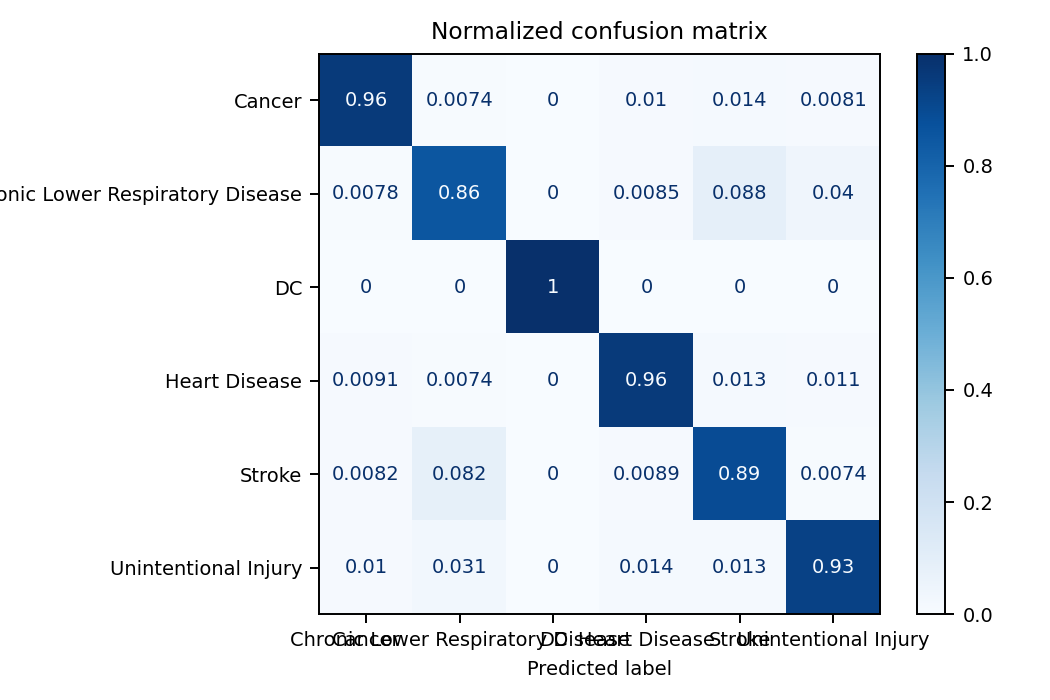

In [ ]:
eval_confusion_matrix_path = os.path.join(eval_path, "val_confusion_matrix.png")
display(Image(filename=eval_confusion_matrix_path))